In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

from combine_ratios import *


In [2]:
# format: Ex    x   y
ratios = np.loadtxt("ratios.txt")
# ratios = np.loadtxt("ratios_fake.txt")

# aribrarity starting at a "later" point
ratios = ratios[20:, :]

# get the differnt ratios grouped by the same Ex
Ex, groups = group_by(ratios)
Ngroups = len(groups)

# (log-lin) fit to each group 
fits = [curve_fit(fit_func, group[:, 0], group[:, 1])
        for group in groups]

# ratios for each group
xs = [group[:, 0] for group in groups]

The "sewing" works is implemented like this:
- I make a log linear fit to each "group" of ratios.
- I define an ordering of the group, where the lowest group is from the lowest Ex_initial, here `ExI = 2.2`
- I find the `yvalue` of the fit at `x_mean(group[i])`  for group `i` and group `i+1`
- Then I scale group `i+1`  with `yvalue[i]/yvalue[i+1]`
- I repeat this for all `i` (except of course the last one...)

In [3]:
# This version turn around the group structure: Start at highest Ex, go down to low Ex (just as a test)
scaling = np.ones(Ngroups)
for i, x in reversed(list(enumerate(xs))):
    if i == 0:
        break
    xmean = np.mean(x)
    popt_first = fits[i][0]
    popt_next = fits[i-1][0]

    yfirst = fit_func(xmean, *popt_first) * scaling[i]
    ynext = fit_func(xmean, *popt_next) * scaling[i-1]

    scaling[i-1] = yfirst/ynext

In [4]:
# compare to known input
gsf_true = np.loadtxt("../gsf.txt")

In [5]:
def plot(gsf_scaling=0.05):
    fig, ax = plt.subplots()

    ax.plot(gsf_true[:, 0], gsf_true[:, 1]*gsf_scaling, "k--", alpha=0.7, label="input")
    
    fit_values_x = np.array([])
    fit_values_y = np.array([])
#     for Ex_tmp, x, (popt, pcov), scale in zip(Ex, xs, fits, scaling):
#         fit_values_x = np.append(fit_values_x, x)
#         fit_values_y = np.append(fit_values_y, fit_func(x, *popt) * scale)
#         ax.plot(x, fit_func(x, *popt) * scale, alpha=0.5, label=f"{Ex_tmp}")
#         # print(np.mean(x))
        
    for Ex_tmp, group, scale in zip(Ex, groups, scaling):
        ax.plot(group[:, 0], group[:, 1] * scale, alpha=0.5, label=f"{Ex_tmp}")
        # print(np.mean(x))

    
        
    fig.legend(ncol=5)
    ax.set_yscale("log")
    return fig, ax

In [6]:
# the absolute scaing is a free parameter
interact(plot, gsf_scaling=(0.05, 1.5, 0.01))

interactive(children=(FloatSlider(value=0.05, description='gsf_scaling', max=1.5, min=0.05, step=0.01), Output…

<function __main__.plot(gsf_scaling=0.05)>

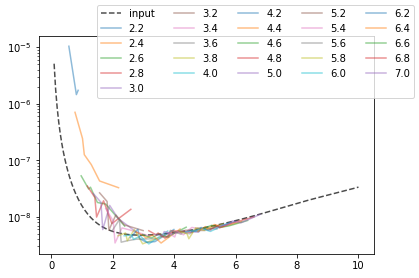

In [7]:
fig, ax = plot(gsf_scaling=1.05)
fig.savefig("ratios.png")

In [8]:
# test what would happen with a faked set

In [9]:
ratios_fake = ratios.copy()
fgsf = log_interp1d(gsf_true[:, 0], gsf_true[:, 1])
ratios_fake[:, 2] = fgsf(ratios_fake[:, 1])
np.savetxt("ratios_fake.txt", ratios_fake)